Import necessary items

In [1]:
import numpy as np
import pandas as pd
import timeit
import random
import cv2
import math


from PIL import Image
import pickle as pkl
import glob
import gc
import os
from tqdm import tqdm
import yaml

In [2]:
from pr2_utils import *
# from lidar_pre_processing import *
# from data_initialization import *
# from prediction import *

In [3]:
'''
This function is used to convert the co-ordinats
From Lidar Frame to Vehicle Frame

Input: Coordinates in LIdar Frame (X, Y, Z)
Output: Coordinates in the Vehicle Frame (X, Y, Z)
'''
"""
def convert_lidar_to_world(x, y, z=0):
    # x = x.astype(int)
    # y = y.astype(int)
    # z = z.astype(int)
    one = np.ones(x.shape)
    
    # print()
    # print("Inside Function")
    
    s_l = np.array([x, y, z, one])
    # print()
    # print("Lidar Position")
    # print(s_l.shape)
    # print(s_l)  
    
    s_l = np.transpose(s_l)
    # print()
    # print("Lidar Transpose Position")
    # print(s_l.shape)
    # print(s_l) 
        
    s_l_new = []
    for i in range(len(s_l)):
        s_l_new.append(s_l[i].T.tolist())
    s_l_new = np.array(s_l_new)
    # print()
    # print("Lidar Needed Position")
    # print(s_l_new.shape)
    # print(s_l_new) 
    
    updated_v_T_l = np.array([v_T_l])
    updated_v_T_l = np.repeat(updated_v_T_l, repeats=NUMBER_OF_PARTICLES, axis=0)
    # print()
    # print("Pose")
    # print(updated_v_T_l.shape)
    # print(updated_v_T_l)
                     
    s_v = np.matmul(updated_v_T_l, s_l_new)
    # print()
    # print("SV Calulated")
    # print(s_v.shape)
    # print(s_v)
    
    new_x, new_y, new_z = s_v[:, 0, :].T, s_v[:, 1, :].T, s_v[:, 2, :].T
    # print(new_x)
    # print(new_x, new_y, new_z)    
    return new_x, new_y, new_z
"""
print()

In [4]:
"""
def convert_lidar_to_cell_new(alpha, mu, lidar_data, angle):
    # First of all we will map this lidar in 2D frame
    # Using the angle we will get the approximate
    # Starting:- (x, y) and ending:- (x, y)
    
    # sx, sy = mu[best_approximation, 0], mu[best_approximation, 1]
    sx, sy = np.array([mu[:, 0]]), np.array([mu[:, 1]])
    
    # This part is do 
    indValid = np.logical_and((lidar_data < LIDAR_MAX),(lidar_data > LIDAR_MIN))
    lidar_data = lidar_data[indValid]
    angle = angle[indValid]
    
    # xy position in the sensor frame    
    x_lidar = lidar_data*np.cos(angle)
    y_lidar = lidar_data*np.sin(angle)    
    # print()
    # print("Lidar Actual")
    # print(x_lidar[0])
    
    # convert position in the map frame here 
    Y_Lidar = np.stack((x_lidar, y_lidar))
    row, col = Y_Lidar.shape    
    # print()
    # print("Y_LIDAR")
    # print(row, col)
    # print(Y_Lidar[0, 0])   
    
    sx = np.repeat(sx, repeats=col, axis=0)
    sy = np.repeat(sy, repeats=col, axis=0)
    
    # Matrix Transformation    
    lidar_x = np.transpose(np.array([Y_Lidar[0, :]]))
    lidar_x = np.repeat(lidar_x, repeats=NUMBER_OF_PARTICLES, axis=1)
    
    lidar_y = np.transpose(np.array([Y_Lidar[1, :]]))
    lidar_y = np.repeat(lidar_y, repeats=NUMBER_OF_PARTICLES, axis=1)
    
    # print()
    # print("Lidar_x, Lidar_y ")
    # print(lidar_x.shape, lidar_y.shape)
    # print(lidar_x[0], lidar_y[0])
    
    ex = lidar_x + sx
    ey = lidar_y + sy
    ez = np.zeros(ex.shape)
    # print()
    # print("Ex, EY")
    # print(ex[0], ey[0])
    
    vehicle_x, vehicle_y, vehicle_z = convert_lidar_to_world(ex, ey, ez)
    # print()
    # print("vehicle_x, vehicle_x ")
    # print(vehicle_x.shape, vehicle_y.shape)
    # print(vehicle_x[0], vehicle_y[0])
    
    Y_World = np.stack((vehicle_x, vehicle_y))
    # print()
    # print("Y_World")
    # print(Y_World.shape)
    # print(Y_World)
        
    return Y_World
"""
print()

In [5]:
'''
This will help to create an empty map of the world
We will start will small
This is not dynamic, we manually the values.

Input: N length in one direction
Output: NxN Matrix with zeros
'''
def create_map(N, M):
    world_map = np.zeros((N, M), dtype=np.int8)
    return world_map

In [6]:
def initialize_particles(N):
    '''
        There will be two matrix
        1. Initial Particle set mu=[0, 0, 0]T. This will be Nx3 in size [X, Y, Theta]
        2. Initial Weight Vector alpha = [1/N]. This will be Nx1 in size 
    '''
    mu = np.zeros((N, 3), dtype=np.int32)
    alpha = np.full((N, 1), 1/N)
    
    return mu, alpha    

In [7]:
mu, alpha = initialize_particles(1)
print(mu)
print(alpha)

[[0 0 0]]
[[1.]]


## Lidar Hyper-parameters

    Hyperparameters of Lidar
    FOV: 190 (degree)
    Start angle: -5 (degree)
    End angle: 185 (degree)
    Angular resolution: 0.666 (degree)
    Max range: 80 (meter)
    
LiDAR rays with value 0.0 represent infinite range observations.

This means there is no obstruction within the range of 80 meters

In [8]:
'''
This function is used to load the lidar data
This lidar data is generally present in "data/sensor_data/lidar.csv"
But you pass it as a filename as well

Input :- File Location
Output :- Returns the angle, timestamp, and lidar data
'''
def get_lidar_data(filename="data/sensor_data/lidar.csv"):
    time_stamp, lidar_data = read_data_from_csv(filename)
    angle = np.linspace(-5, 185, 286) / 180 * np.pi
    # print(lidar_data.shape)
    
    return angle, time_stamp, lidar_data

In [9]:
angle, lidar_time_stamp, lidar_data = get_lidar_data()

In [10]:
first_lidar_data = lidar_data[0]
# first_lidar_data

## Encoder Hyper-parameters

    Encoder calibrated parameter
    Encoder resolution: 4096
    Encoder left wheel diameter: 0.623479
    Encoder right wheel diameter: 0.622806
    Encoder wheel base: 1.52439

The encoder data is stored as \[timestamp, left count, right count\].

In [11]:
'''
This function is used to load the encoder data
This encoder data is generally present in "data\sensor_data\encoder.csv"
But you pass it as a filename as well

Input :- File Location
Output :- Returns the timestamp and wheel count
'''
def get_encoder_data(filename="data/sensor_data/encoder.csv"):
    time_stamp, wheel_count = read_data_from_csv(filename)    
    return time_stamp, wheel_count
    

In [12]:
encoder_time_stamp, wheel_count = get_encoder_data()
wheel_count[0]

array([69577, 69699], dtype=int64)

## FOG Hyper-parameters

    FOG (Fiber Optic Gyro) extrinsic calibration parameter from vehicle
    RPY(roll/pitch/yaw = XYZ extrinsic, degree), R(rotation matrix), T(translation matrix, meter)
    RPY: [0 0 0]
    R: [[1, 0, 0]
        [0, 1, 0]
        [0, 0, 1]
    T: [-0.335 -0.035 0.78]

The sensor measurements are stored as \[timestamp, delta roll, delta pitch, delta yaw\] in radians.

In [13]:
'''
This function is used to load the fog data
This encoder data is generally present in "data\sensor_data\fog.csv"
But you pass it as a filename as well

Input :- File Location
Output :- Returns the timestamp and fog_data, only yaw required
'''
def get_fog_data(filename="data/sensor_data/fog.csv"):
    time_stamp, fog_data = read_data_from_csv(filename)
    # print(fog_data[0])
    fog_yaw = fog_data[:, 2]
    
    
    return time_stamp, fog_yaw

In [14]:
fog_time_stamp, fog_yaw = get_fog_data()
fog_yaw[0]

-1.1969166735070756e-05

## Fundamental Parameters of Lidar Sensors

Lidar sensor (LMS511) extrinsic calibration parameter from vehicle.

    RPY(roll/pitch/yaw = XYZ extrinsic, degree), R(rotation matrix), T(translation matrix)
    RPY: [142.759, 0.0584636, 89.9254]
This part is used if we want to use Euler format instead of rotation matrix.

    R: [[ 0.00130201,     0.796097,    0.605167]
        [   0.999999, -0.000419027, -0.00160026]
        [-0.00102038,     0.605169,   -0.796097]]
        
    T: [0.8349, -0.0126869, 1.76416]
In our case we are directly given the Rotation matrix which saves a small computation

In [15]:
v_R_l = np.array([[ 0.00130201,     0.796097,    0.605167],
                  [   0.999999, -0.000419027, -0.00160026],
                  [-0.00102038,     0.605169,   -0.796097]])
        
v_P_l = np.array([0.8349, -0.0126869, 1.76416])

Zero_T = np.zeros((3))


v_T_l = np.array([[ 0.00130201,     0.796097,    0.605167,     0.8349],
                  [   0.999999, -0.000419027, -0.00160026, -0.0126869],
                  [-0.00102038,     0.605169,   -0.796097,    1.76416],
                  [          0,            0,           0,          1]])

l_T_v = np.array([[0.00130201,       0.999999,   -0.00102038,    0.01339995],
                  [  0.796097,   -0.000419027,      0.605169,   -1.73228164],
                  [  0.605167,    -0.00160026,     -0.796097,    0.89916825],
                  [         0,              0,             0,        1.0000]])

## Prediction Step

In the prediction step we add noise to next step

Velocity of Left Wheel is 
* vl = (np.pi * encoder_wheel_base * encoder_left_wheel_data) / encoder_resolution*tau
    
Velocity of Right Wheel is 
* vl = (np.pi * encoder_wheel_base * encoder_right_wheel_data) / encoder_resolution*tau
    
But we will not multiply two times and average it
* v = ((np.pi * encoder_wheel_base) / encoder_resolution*tau )*(encoder_left_wheel_data + encoder_right_wheel_data)

The Theta_t is available from FOG data
Theta_t = delta_yaw / delta timestamp

In [16]:
encoder_resolution = 4096
encoder_left_diameter = 0.623479
encoder_right_diameter = 0.622806
encoder_wheel_base = 1.52439

In [17]:
def approximately_equal(number_1, number_2):
    return math.isclose(number_1, number_2, rel_tol=0.000000000001)

In [229]:
'''
This function is used to predict the next step of the model
Depending on the next step
We will try to rearange things

Input: Position of the Particle/Particles
Output: Updated position of the Particles using the motion model
'''
def prediction_step(alpha, mu, robot=False):
    # Noise Term
    # Activate when you are ready for the whole dataset
    # This normal(mean, standard_deviation, number_of_values)
    # print(mu)
    
    # noise = np.array([[0, 0, 0]])
    # print(noise)
    
    # Global Variables
    global global_encoder_previous_time_stamp
    global global_encoder_current_time_stamp
    global global_fog_previous_time_stamp
    global global_fog_current_time_stamp
    global robot_path
    
    # Function
    global_encoder_current_time_stamp = global_encoder_previous_time_stamp + 1
    global_fog_current_time_stamp = global_fog_previous_time_stamp + 1    
    
    # print("Encoder previous: ", global_encoder_previous_time_stamp)
    # print("Encoder current: ", global_encoder_current_time_stamp)
    
    # Keep track of timestamp of encoder which is used as tau
    previous_encoder_time = encoder_time_stamp[global_encoder_previous_time_stamp]
    current_encoder_time = encoder_time_stamp[global_encoder_current_time_stamp]
    
    # print()
    # print("FOG previous: ", global_fog_previous_time_stamp)   
    # Keep track of timestamp of fog which is used to get delta_yaw
    previous_fog_time = fog_time_stamp[global_fog_previous_time_stamp]
    while True:
        current_fog_time = fog_time_stamp[global_fog_current_time_stamp]
        if approximately_equal(current_fog_time, current_encoder_time):
            break
        else:
            global_fog_current_time_stamp = global_fog_current_time_stamp + 1    
    # print("FOG current: ", global_fog_current_time_stamp)      
    
    # Velocity of Wheel
    encoder_left_wheel_data = wheel_count[global_encoder_current_time_stamp, 0] - wheel_count[global_encoder_previous_time_stamp, 0]
    encoder_right_wheel_data = wheel_count[global_encoder_current_time_stamp, 1] - wheel_count[global_encoder_previous_time_stamp, 1]
    tau = current_encoder_time - previous_encoder_time
    vl = (np.pi * encoder_left_diameter * encoder_left_wheel_data) / (encoder_resolution*tau)
    vr = (np.pi * encoder_right_diameter * encoder_right_wheel_data) / (encoder_resolution*tau)
    v = (vl + vr) / 2
    
    # Theta_t of Fog
    delta_yaw = sum(fog_yaw[global_fog_previous_time_stamp:global_fog_current_time_stamp])
    theta_t = mu[:, 2]
    
    # Adding the noise term to omega
    # Mean=0 and Varince=1e-12
    # noise = np.random.normal(0, 0, theta_t.shape)
    np.random.seed(56)
    noise_v = np.random.normal(0, 1e-10, v.shape)
    noise_omega = np.random.normal(0, 1e-13, theta_t.shape)
    
    # Omega for the angular velocity
    omega = np.full(theta_t.shape, (delta_yaw) / tau)
    
    v = v # + noise_v
    omega = omega # + noise_omega
    
    # X_current is the current position of the robot
    x_current = mu
    x = v*np.cos(theta_t) # + noise_x
    y = v*np.sin(theta_t) # + noise_y
    omega = omega
    
    # Convert to vectorize form
    se = np.transpose(np.vstack([x, y, omega]))
    sv = tau * se
    
    x_next = x_current + sv
    # print()
    # print(x_next.shape)
    # print(x_next)
    
    # This is helpful just to create the trajectory
    # Can be commented later in order to save time
    # ex = float(x_next[:, 0])*math.cos(omega)
    # ey = float(x_next[:, 1])*math.sin(omega)
    # ez = 0
    # robot_path.append([[ex, ey, ez]])
    if robot == True:
        max_alpha_position = np.argmax(alpha)
        new_position = x_next[max_alpha_position].tolist()
        robot_path.append([new_position])
    
    # Once I have x_next I will make the theta_t+1 = 0 and convert it into world frame.
    # This might be helpful for plotting things
    
    # Velocity:  4.635729231838156
    # Theta:  [0]
    # Omega:  [-0.01692147]
    # print()
    # print("Velocity: ", v*1e+9)    
    # print("Theta: ", theta_t)
    # print("Omega: ", omega*1e+9)
    
    # print()
    # print("Tau: ", tau)
    # print("Delta T: ", delta_t)
    '''
    print()
    print(x_current)  
    print(sv)    
    print(x_next)
    '''
    
    global_encoder_previous_time_stamp = global_encoder_current_time_stamp 
    global_fog_previous_time_stamp = global_fog_current_time_stamp    
    return x_next

In [230]:
print(wheel_count.shape)
print(fog_yaw.shape)

mu, alpha = initialize_particles(1)

# This is to get the path of the robot
# Each iteration I will add x, y coordinates in this list
robot_path = [[[0, 0, 0]]]

# Global Counter variables
global_encoder_previous_time_stamp = 0
global_encoder_current_time_stamp = 0

global_fog_previous_time_stamp = 0
global_fog_current_time_stamp = 0

for i in range(116047):
    mu = prediction_step(alpha, mu, robot=True)
    # continue

(116048, 2)
(1160508,)


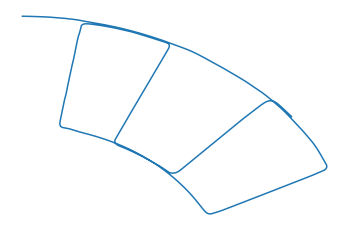

In [237]:
robot_path = np.array(robot_path)

folder = "D:/University of California San Diego/Quater 2/ECE276A/Assignment 2/harsh_ece276a_pr2/report/Images/"
name = "dead_reckoning.png"

# plt.figure(figsize=(10, 10), dpi=256)
plt.plot(robot_path[:, :, 0], robot_path[:, :, 1])
plt.axis('off')
plt.savefig(folder+name)
plt.show()

In [29]:
# Global Counter variables
global_encoder_previous_time_stamp = 0
global_encoder_current_time_stamp = 0
global_fog_previous_time_stamp = 0
global_fog_current_time_stamp = 0
global_lidar_counter = 0

# This part is done is to create the empty map
# World map is the map we are using it to visulize the surronding
# Map Parameters
map_res     =  1 #meters
map_x_min   = -300  #meters
map_x_max   =  1500
map_y_min   = -1500
map_y_max   =  400
map_size_x  = int(np.ceil((map_x_max - map_x_min) / map_res + 1)) #cells
map_size_y  = int(np.ceil((map_y_max - map_y_min) / map_res + 1))

x_im = np.arange(map_x_min, map_x_max+map_res, map_res) #x-positions of each pixel of the map
y_im = np.arange(map_y_min, map_y_max+map_res, map_res) #y-positions of each pixel of the map
# x_range = np.arange(-4*map_res, (4*map_res)+map_res, map_res)
# y_range = np.arange(-4*map_res, (4*map_res)+map_res, map_res)
x_range = np.arange(1*map_res, 1*map_res+map_res, map_res)
y_range = np.arange(1*map_res, 1*map_res+map_res, map_res)
size_x_range = len(x_range)
size_y_range = len(y_range)
mid_x_range = size_x_range//2
mid_y_range = size_y_range//2
    
grid_map = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
free_map = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
# road_map = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
# log_map  = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
log_map = np.zeros((map_size_x, map_size_y))  #DATA TYPE: char or int8
texture_map = np.zeros((map_size_x, map_size_y, 3), np.uint8)

NUMBER_OF_PARTICLES = 10
N_THRESHOLD = int(NUMBER_OF_PARTICLES*30/100)
LIDAR_MAX = 60
LIDAR_MIN = 5

robot_path = [[[0, 0, 0]]]

# Intialize the particle and the weights
mu, alpha = initialize_particles(NUMBER_OF_PARTICLES)

-------------------------------------------------------------------

In [30]:
# def create_grid_map(mu, grid_map, Y):
#     # new_grid_map = np.zeros(grid_map.shape)
#     # print()
#     # print()
#     # print("Inside GRID MAP")
    
#     # print()
#     # print("Position")
#     # print(mu.shape)
#     # print(mu)
    
#     # print()
#     # print("Y 0")
#     # print(Y.shape)
#     # 2, 160
#     # print(Y)
    
#     xis = np.ceil((Y[0, :] - map_x_min) / map_res ).astype(np.int16)-1
#     yis = np.ceil((Y[1, :] - map_y_min) / map_res ).astype(np.int16)-1
    
#     # print()
#     # print("XIS, YIS")
#     # print(xis.shape, yis.shape)
#     # print(xis)
#     # print(yis)
    
#     # build an arbitrary map 
#     indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < map_size_x)), (yis < map_size_y))
#     grid_map[xis[indGood], yis[indGood]] = 1
    
#     # grid_map = np.add(grid_map, new_grid_map)
    
#     # fig2 = plt.figure()
#     # plt.imshow(grid_map, cmap="gray");
#     # plt.title("Occupancy grid map")
    
#     return grid_map

In [96]:
def compute_disparity(path_l, path_r):
    # path_l = 'data/image_left.png'
    # path_r = 'data/image_right.png'

    image_l = cv2.imread(path_l, 0)
    image_r = cv2.imread(path_r, 0)

    image_l = cv2.cvtColor(image_l, cv2.COLOR_BAYER_BG2BGR)
    image_r = cv2.cvtColor(image_r, cv2.COLOR_BAYER_BG2BGR)

    image_l_gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
    image_r_gray = cv2.cvtColor(image_r, cv2.COLOR_BGR2GRAY)

    # You may need to fine-tune the variables `numDisparities` and `blockSize` based on the desired accuracy
    stereo = cv2.StereoBM_create(numDisparities=32, blockSize=9)
    disparity = stereo.compute(image_l_gray, image_r_gray)
    # print(type(disparity))    

    # fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    # ax1.imshow(image_l)
    # ax1.set_title('Left Image')
    # ax2.imshow(image_r)
    # ax2.set_title('Right Image')
    # ax3.imshow(disparity, cmap='gray')
    # ax3.set_title('Disparity Map')
    # plt.show()
    
    return image_l, disparity

In [97]:
# Creating and storing all the disparity map as pickel
current_dir = "D:/University of California San Diego/Quater 2/ECE276A/Assignment 2/ECE276A_PR2/code/"
left_image_folder = current_dir + "data/stereo_images/stereo_left/"
right_image_folder = current_dir + "data/stereo_images/stereo_right/"

rgb_image_folder = current_dir + "data/stereo_images/stereo_rgb/"
dis_image_folder = current_dir + "data/stereo_images/stereo_dis/"
texture_map_folder = current_dir + "data/output/texture_map/"

# os.chdir(image_folder)

left_images = [img for img in os.listdir(left_image_folder)
                  if img.endswith(".jpg") or
                     img.endswith(".jpeg") or
                     img.endswith("png")]

right_images = [img for img in os.listdir(right_image_folder)
                  if img.endswith(".jpg") or
                     img.endswith(".jpeg") or
                     img.endswith("png")]

left_path = os.path.join(left_image_folder, left_images[0])
right_path = os.path.join(right_image_folder, right_images[0])
rgb_path = rgb_image_folder
dis_path = dis_image_folder

# i = 0
# num = str(i)
# num = num.zfill(4)
# print(left_images[0] == right_images[0])

# empty list for rgb and disparity
rgb_images = []
disparity_images = []
stereo_time_stamp = []

len_img = len(left_images)
# rgb_images, disparity_images = compute_disparity(left_path, right_path)

for i in range(len_img):
    if left_images[i] == right_images[i]:
        stereo_time_stamp.append(int(left_images[i][:-4]))
        bgr_image, disparity_image = compute_disparity(left_path, right_path)
        rgb_images.append(bgr_image), disparity_images.append(disparity_image)
        
len_img = len(rgb_images)      
for i in range(len_img):
    rgb = cv2.cvtColor(rgb_images[i], cv2.COLOR_BGR2RGB)
        

rgb_images, disparity_images, stereo_time_stamp = np.asarray(rgb_images), np.asarray(disparity_images), np.asarray(stereo_time_stamp)
print("RGB: ", rgb_images.shape)
print("Disparity: ", disparity_images.shape)

dis_file = open(str(dis_path+"disparity.pkl"), "wb")
pkl.dump(disparity_images, dis_file)
dis_file.close()

rgb_file = open(str(rgb_path+"rgb.pkl"), "wb")
pkl.dump(rgb_images, rgb_file)
rgb_file.close()

RGB:  (1113, 560, 1280, 3)
Disparity:  (1113, 560, 1280)


In [33]:
def resmaple_step(alpha, mu):
    # print()
    # print("Alpha")
    # print(alpha)
    
    alpha_square = alpha*alpha
    # print()
    # print("Alpha Square")
    # print(alpha_square)
    # print(sum(alpha_square))
    
    N_EFFECTIVE = int(1 / sum(alpha_square))
    if N_EFFECTIVE < N_THRESHOLD:
        # print(N_EFFECTIVE)
        
        # print()
        # print("Original")
        # for i in range(NUMBER_OF_PARTICLES):
        #     print("A", alpha[i], " ----> P", mu[i])        
        
        result = np.sort(alpha)[N_THRESHOLD, 0]
        new_alpha = np.where(alpha<result, 0, alpha)
        new_alpha = new_alpha / sum(new_alpha)
            
        particle_index = np.array(NUMBER_OF_PARTICLES)
        selection = np.random.choice(particle_index, NUMBER_OF_PARTICLES, p=new_alpha.reshape(len(new_alpha),))
        mu = mu[selection]
        alpha = np.full((NUMBER_OF_PARTICLES, 1), 1/NUMBER_OF_PARTICLES)
        
        # print()
        # print("Updated MU")
        #  for i in range(NUMBER_OF_PARTICLES):
        #     print("A", alpha[i], " ----> P", mu[i])
        
        
        
    return alpha, mu
    

In [34]:
def world_T_vehicle(theta, x, y, NUMBER_OF_PARTICLES=NUMBER_OF_PARTICLES):
    # print()
    # print("Theta")
    # print(theta[0, 0])
    
    # print()
    # print("X, Y")
    # print(x[0, 0], y[0, 0])
    w_T_v = []
    for i in range(NUMBER_OF_PARTICLES):
        w_T_v.append([[math.cos(theta[0, i]), -math.sin(theta[0, i]),    0,    x[0, i]],
                      [math.sin(theta[0, i]),  math.cos(theta[0, i]),    0,    y[0, i]],
                      [                    0,                      0,    1,          0],
                      [                    0,                      0,    0,          1]])
        
    '''   
    w_T_v = np.array([[np.cos(theta), -np.sin(theta),    0,    x],
                      [np.sin(theta),  np.cos(theta),    0,    y],
                      [            0,              0,    1,    0],
                      [            0,              0,    0,    1]])
    '''
    w_T_v = np.array(w_T_v)
    
    return w_T_v

In [35]:
def convert_lidar_to_world(NUMBER_OF_PARTICLES, x, y, z, w_T_v):
    '''
    This function is used to convert the co-ordinats
    From Lidar Frame to Vehicle Frame

    Input: Coordinates in LIdar Frame (X, Y, Z)
    Output: Coordinates in the Vehicle Frame (X, Y, Z)
    '''
    
    # x = x.astype(int)
    # y = y.astype(int)
    # z = z.astype(int)
    one = np.ones(x.shape)
    
    # print()
    # print("Inside Function")
    
    s_l = np.array([x, y, z, one])
    # print()
    # print("Lidar Position")
    # print(s_l.shape)
    # print(s_l)  
    
    s_l = np.transpose(s_l)
    # print()
    # print("Lidar Transpose Position")
    # print(s_l.shape)
    # print(s_l) 
        
    s_l_new = []
    for i in range(len(s_l)):
        s_l_new.append(s_l[i].T.tolist())
    s_l_new = np.array(s_l_new)
    # print()
    # print("Lidar Needed Position")
    # print(s_l_new.shape)
    # print(s_l_new) 
    
    updated_v_T_l = np.array([v_T_l])
    updated_v_T_l = np.repeat(updated_v_T_l, repeats=NUMBER_OF_PARTICLES, axis=0)
    # print()
    # print("Pose")
    # print(updated_v_T_l.shape)
    # print(updated_v_T_l)
    
    pose_matrix = np.matmul(w_T_v, updated_v_T_l)
    # print()
    # print("Pose Multiplication")
    # print(pose_matrix.shape)
    # print(pose_matrix)
    
    s_v = np.matmul(pose_matrix, s_l_new)
    # print()
    # print("SV Calulated")
    # print(s_v.shape)
    # print(s_v)
    
    new_x, new_y, new_z = s_v[:, 0, :].T, s_v[:, 1, :].T, s_v[:, 2, :].T
    # print(new_x)
    # print(new_x, new_y, new_z)    
    return new_x, new_y, new_z

In [36]:
def convert_lidar_to_cell_new(alpha, mu, lidar_data, angle, NUMBER_OF_PARTICLES):
    # First of all we will map this lidar in 2D frame
    # Using the angle we will get the approximate
    # Starting:- (x, y) and ending:- (x, y)
    
    # sx, sy = mu[best_approximation, 0], mu[best_approximation, 1]
    sx, sy, sz = np.array([mu[:, 0]]), np.array([mu[:, 1]]), np.array([mu[:, 2]])
    
    # This part is do 
    indValid = np.logical_and((lidar_data < 60),(lidar_data > 0.1))
    lidar_data = lidar_data[indValid]
    angle = angle[indValid]
    
    # xy position in the sensor frame    
    x_lidar = lidar_data*np.cos(angle)
    y_lidar = lidar_data*np.sin(angle)
    zeros   = np.zeros(x_lidar.shape)
    ones    = np.ones(x_lidar.shape)
    
    # Theta of the Lidar
    z_lidar = sz
    # print()
    # print("Theta of Lidar")
    # print(z_lidar)
    
    # Get the Transformation Matrix
    w_T_v = world_T_vehicle(z_lidar, sx, sy)
    # print()
    # print("world_T_robot")
    # print(w_T_v.shape)
    # print(w_T_v)
    
    # convert position in the map frame here 
    Y_Lidar = np.stack((x_lidar, y_lidar, zeros, ones))
    row, col = Y_Lidar.shape    
    # print()
    # print("Y_LIDAR")
    # print(row, col)
    # print(Y_Lidar[:, 0])   
    # print(Y_Lidar[:, 1])  
    
    sx = np.repeat(sx, repeats=col, axis=0)
    sy = np.repeat(sy, repeats=col, axis=0)
    
    # Matrix Transformation    
    lidar_x = np.transpose(np.array([Y_Lidar[0, :]]))
    lidar_x = np.repeat(lidar_x, repeats=NUMBER_OF_PARTICLES, axis=1)
    
    lidar_y = np.transpose(np.array([Y_Lidar[1, :]]))
    lidar_y = np.repeat(lidar_y, repeats=NUMBER_OF_PARTICLES, axis=1)
    
    # print()
    # print("Lidar_x, Lidar_y ")
    # print(lidar_x.shape, lidar_y.shape)
    # print(lidar_x, lidar_y)
    
    ex = lidar_x
    ey = lidar_y
    ez = np.zeros(ex.shape)
    # print()
    # print("Ex, EY")
    # print(ex[0], ey[0])
    
    vehicle_x, vehicle_y, vehicle_z = convert_lidar_to_world(NUMBER_OF_PARTICLES, ex, ey, ez, w_T_v)
    # print()
    # print("vehicle_x, vehicle_x ")
    # print(vehicle_x.shape, vehicle_y.shape)
    # print(vehicle_x[0], vehicle_y[0])
    
    Y_World = np.stack((vehicle_x, vehicle_y))
    # print()
    # print("Y_World")
    # print(Y_World.shape)
    # print(Y_World)
        
    return Y_World

In [37]:
'''
From the prediction step we will get different position of the particles
This is done by adding Gaussian noise.

For each position we update the alpha using the co-relation with the original lidar.
After each update step don't forget to normalize it.

Input: is the original weight
Output: is the updated weight
'''

# This is to get the path of the robot
# Each iteration I will add x, y coordinates in this list
robot_path = [[[0, 0, 0]]]

def update_step(mu, alpha, Y_World, log_map, grid_map, free_map):
    # Global Variables
    global global_lidar_counter
    
    # print(global_lidar_counter)
    # print()
    # print("Inside Update")
    
    # Get the next lidar
    # T1
    current_lidar_data = lidar_data[global_lidar_counter]
    global_lidar_counter = global_lidar_counter + 1  # update the lidar count so it will read next time
    
    # Get all the information related to x_is, y_is and Y_World
    # This all data will be available from the convert_lidar_to_cell_new function
    Y_World = convert_lidar_to_cell_new(alpha, mu, current_lidar_data, angle, NUMBER_OF_PARTICLES)
    # print()
    # print("Y World")
    # print(Y_World.shape)
    
    # This is just the LiDar data
    # We get different Correlation matrix "c" for different particles
    correlation = []
    total = 0
    best_particle = 0
    max_alpha = 0
    
    for i in range(NUMBER_OF_PARTICLES):
        # Get the weight of the particle
        alpha_i = alpha[i]
        # print()
        # print("Weight", alpha_i)
        
        # Get the position of the first particle
        # print()
        # print("Iteration", i)
        
        mu_i = np.array(mu[i])        
        # print()
        # print("Position inside update")
        # print(mu_i.shape)
        
        # Get the corresponding Y_World of that particle
        y_world_particle = Y_World[:, :, i]
        # print()
        # print("Y_World inside For")
        # print(y_world_particle.shape)
        # print(y_world_particle)
        
        # temp_grid_map = create_grid_map(mu_i, grid_map, Y_World)
        # _, temp_grid_map, _ = log_odds_function(mu_i, log_map, grid_map, free_map, y_world_particle, TEMP=False)
        c = mapCorrelation(grid_map, x_im, y_im, y_world_particle, x_range, y_range)
        # print()
        # print("Correlation Matrix")
        # print(c.shape)
        # print(c)
        
        max_c = c[mid_x_range, mid_y_range]
        max_position_c = np.argmax(c)
        # print()
        # print("Max Correlation Value")
        # print(max_c)
        # correlation.append(np.exp(max_c))
        correlation.append(max_c)
        
        # x, y = max_position_c/size_x_range*map_res, max_position_c/size_y_range*map_res
        # print()
        # print("Small Position Update")
        # print(x, y)
        
        # mu[i, 0], mu[i, 1] = mu[i, 0]+x, mu[i, 1]+y
        # print()
        # print("Updated Position")
        # print(mu[i])
    
    # print()
    # print("Original Alpha")
    # print(alpha)
    
    correlation = np.array([correlation]).T
    alpha = alpha * np.exp(correlation)
    # print()
    # print("Correlation")
    # print(correlation)
    
    alpha = alpha / np.sum(alpha)
    # print()
    # print("Updated Alpha")
    # print(alpha)
    
    max_alpha = np.max(alpha)
    max_position_alpha = np.argmax(alpha)
    # print()
    # print("Max Position Alpha")
    # print(max_position_alpha)
    
    ## Keep only the best grid map
    # road_map, grid_map, log_map = create_road_map(alpha, mu, road_map, grid_map, log_map,  Y_World)
    # grid_map = create_grid_map(mu[max_position_alpha] , grid_map, Y_World[:, :, max_position_alpha])
    # log_map = log_odds_function(log_map, Y_World)
    log_map, grid_map, free_map = log_odds_function(mu[max_position_alpha], log_map, grid_map, free_map, Y_World[:, :, max_position_alpha])
    
    # plt.imshow(grid_map, cmap="gray")
    # plt.show(block=True)
    
    # log_map = log_odds(log_map, road_map)
    
    # We create an updated road map and update the log odds
    # This will be done after updating the weights because weights will be taken into consideration
    # road_map = create_road_map(alpha, mu, road_map, Y_World)
    # log_map = log_odds(log_map, road_map)

    new_alpha = alpha
    return new_alpha, log_map, grid_map, free_map

In [38]:
'''
This function is used to update the logs odd from the output obtained by lidar frame
Once we have the lidar coordinates in world frame.
We just do 0 and 1 in lidar frame.
But inorder to make it work for real world map
Use this function to find log odds
'''
def log_odds_function(mu, log_map, grid_map, free_map, Y, TEMP=True):    
    # Main map log_map
    
    
    # print()
    # print()
    # print("Inside Create Road Map")
    
    # Find the best alpha to plot it on the graph 
    # best_approximation = np.argmax(alpha).astype(int)
    # print()
    # print("Best Approximation")
    # print(best_approximation)
    
    # Correct
    # print()
    # print("Y_World inside log odds")
    # print(Y.shape)
    
    # Correct
    world_coordinates = Y #[:, :, best_approximation].astype(int)
    # print()
    # print("World Coordinates")
    # print(world_coordinates.shape)
    # print(world_coordinates)
    
    total_coordinates = len(world_coordinates[0])
    # print()
    # print("Length")
    # print(total_coordinates)
    
    # start_point_x, start_point_y = mu[best_approximation, 0], mu[best_approximation, 1]
    start_point_x, start_point_y = mu[0], mu[1]
    sx = np.ceil((start_point_x - map_x_min) / map_res ).astype(np.int16)-1
    sy = np.ceil((start_point_y - map_y_min) / map_res ).astype(np.int16)-1
    # print()
    # print("Start Point inside log odds")
    # print(start_point_x, start_point_y)
    
    xis = np.ceil((world_coordinates[0, :] - map_x_min) / map_res ).astype(np.int16)-1
    yis = np.ceil((world_coordinates[1, :] - map_y_min) / map_res ).astype(np.int16)-1 
    # print()
    # print("xis, yis")
    # print(xis[0], yis[0])
    
    # This should be done 
    if TEMP:
        em = []    
        for i in range(total_coordinates):
            ex, ey = xis[i], yis[i]
            # log_map[ex, ey] = log_map[ex, ey] + np.log(4)
            # log_map[sx, sy] = log_map[ex, ey] + np.log(4)
            r2 = bresenham2D(sx, sy, ex, ey).astype(int)        
            # x_r2, y_r2 = r2
            # log_map[x_r2, y_r2] = log_map[x_r2, y_r2] - np.log(4)
            em.append(r2)
            # combine = np.array(list(zip(x, y))).tolist()
            # em.extend(combine)
            # print()
            # print(combine)
        # print(f"Output of bresenham :{r2[0]}")
        # temp_log_map = np.zeros(log_map.shape)
        for i in range(total_coordinates):
            log_map[em[i][0][:-1], em[i][1][:-1]] -= np.log(4)

        # Limit the range of the values the log_map can take
        log_map[log_map < -50] = -50
        log_map[log_map > 50] = 50

    log_map[xis, yis] = log_map[xis, yis] + np.log(4)
    
    grid_map = (log_map > 0).astype(np.int8)
    free_map = (log_map < 0).astype(np.int8)
    # indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < map_size_x)), (yis < map_size_y))
    # grid_map[xis[indGood], yis[indGood]] = 1
    # grid_map[xis, yis] = 1
    # grid_map[grid_map > 1] = 1
    
    # log_map = log_map + temp_log_map
    # log_map[log_map < -2] = -2
    # log_map[log_map > 2] = 2
        
    # grid_map = (log_map > 0).astype(np.int8)   
    return log_map, grid_map, free_map

In [238]:
# Global Counter variables
global_encoder_previous_time_stamp = 0
global_encoder_current_time_stamp = 0
global_fog_previous_time_stamp = 0
global_fog_current_time_stamp = 0
global_lidar_counter = 0

# This part is done is to create the empty map
# World map is the map we are using it to visulize the surronding
# Map Parameters
map_res     =  1 #meters
map_x_min   = -50  #meters
map_x_max   =  50
map_y_min   = -50
map_y_max   =  50
map_size_x  = int(np.ceil((map_x_max - map_x_min) / map_res + 1)) #cells
map_size_y  = int(np.ceil((map_y_max - map_y_min) / map_res + 1))

x_im = np.arange(map_x_min, map_x_max+map_res, map_res) #x-positions of each pixel of the map
y_im = np.arange(map_y_min, map_y_max+map_res, map_res) #y-positions of each pixel of the map
# x_range = np.arange(-4*map_res, (4*map_res)+map_res, map_res)
# y_range = np.arange(-4*map_res, (4*map_res)+map_res, map_res)
x_range = np.arange(1*map_res, 1*map_res+map_res, map_res)
y_range = np.arange(1*map_res, 1*map_res+map_res, map_res)
size_x_range = len(x_range)
size_y_range = len(y_range)
mid_x_range = size_x_range//2
mid_y_range = size_y_range//2
    
grid_map = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
free_map = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
# road_map = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
# log_map  = create_map(map_size_x, map_size_y) #DATA TYPE: char or int8
log_map = np.zeros((map_size_x, map_size_y))  #DATA TYPE: char or int8
texture_map = np.ones((map_size_x, map_size_y, 3), np.uint8)

NUMBER_OF_PARTICLES = 10
N_THRESHOLD = int(NUMBER_OF_PARTICLES*30/100)
LIDAR_MAX = 60
LIDAR_MIN = 5

robot_path = [[[0, 0, 0]]]

# Intialize the particle and the weights
mu, alpha = initialize_particles(NUMBER_OF_PARTICLES)

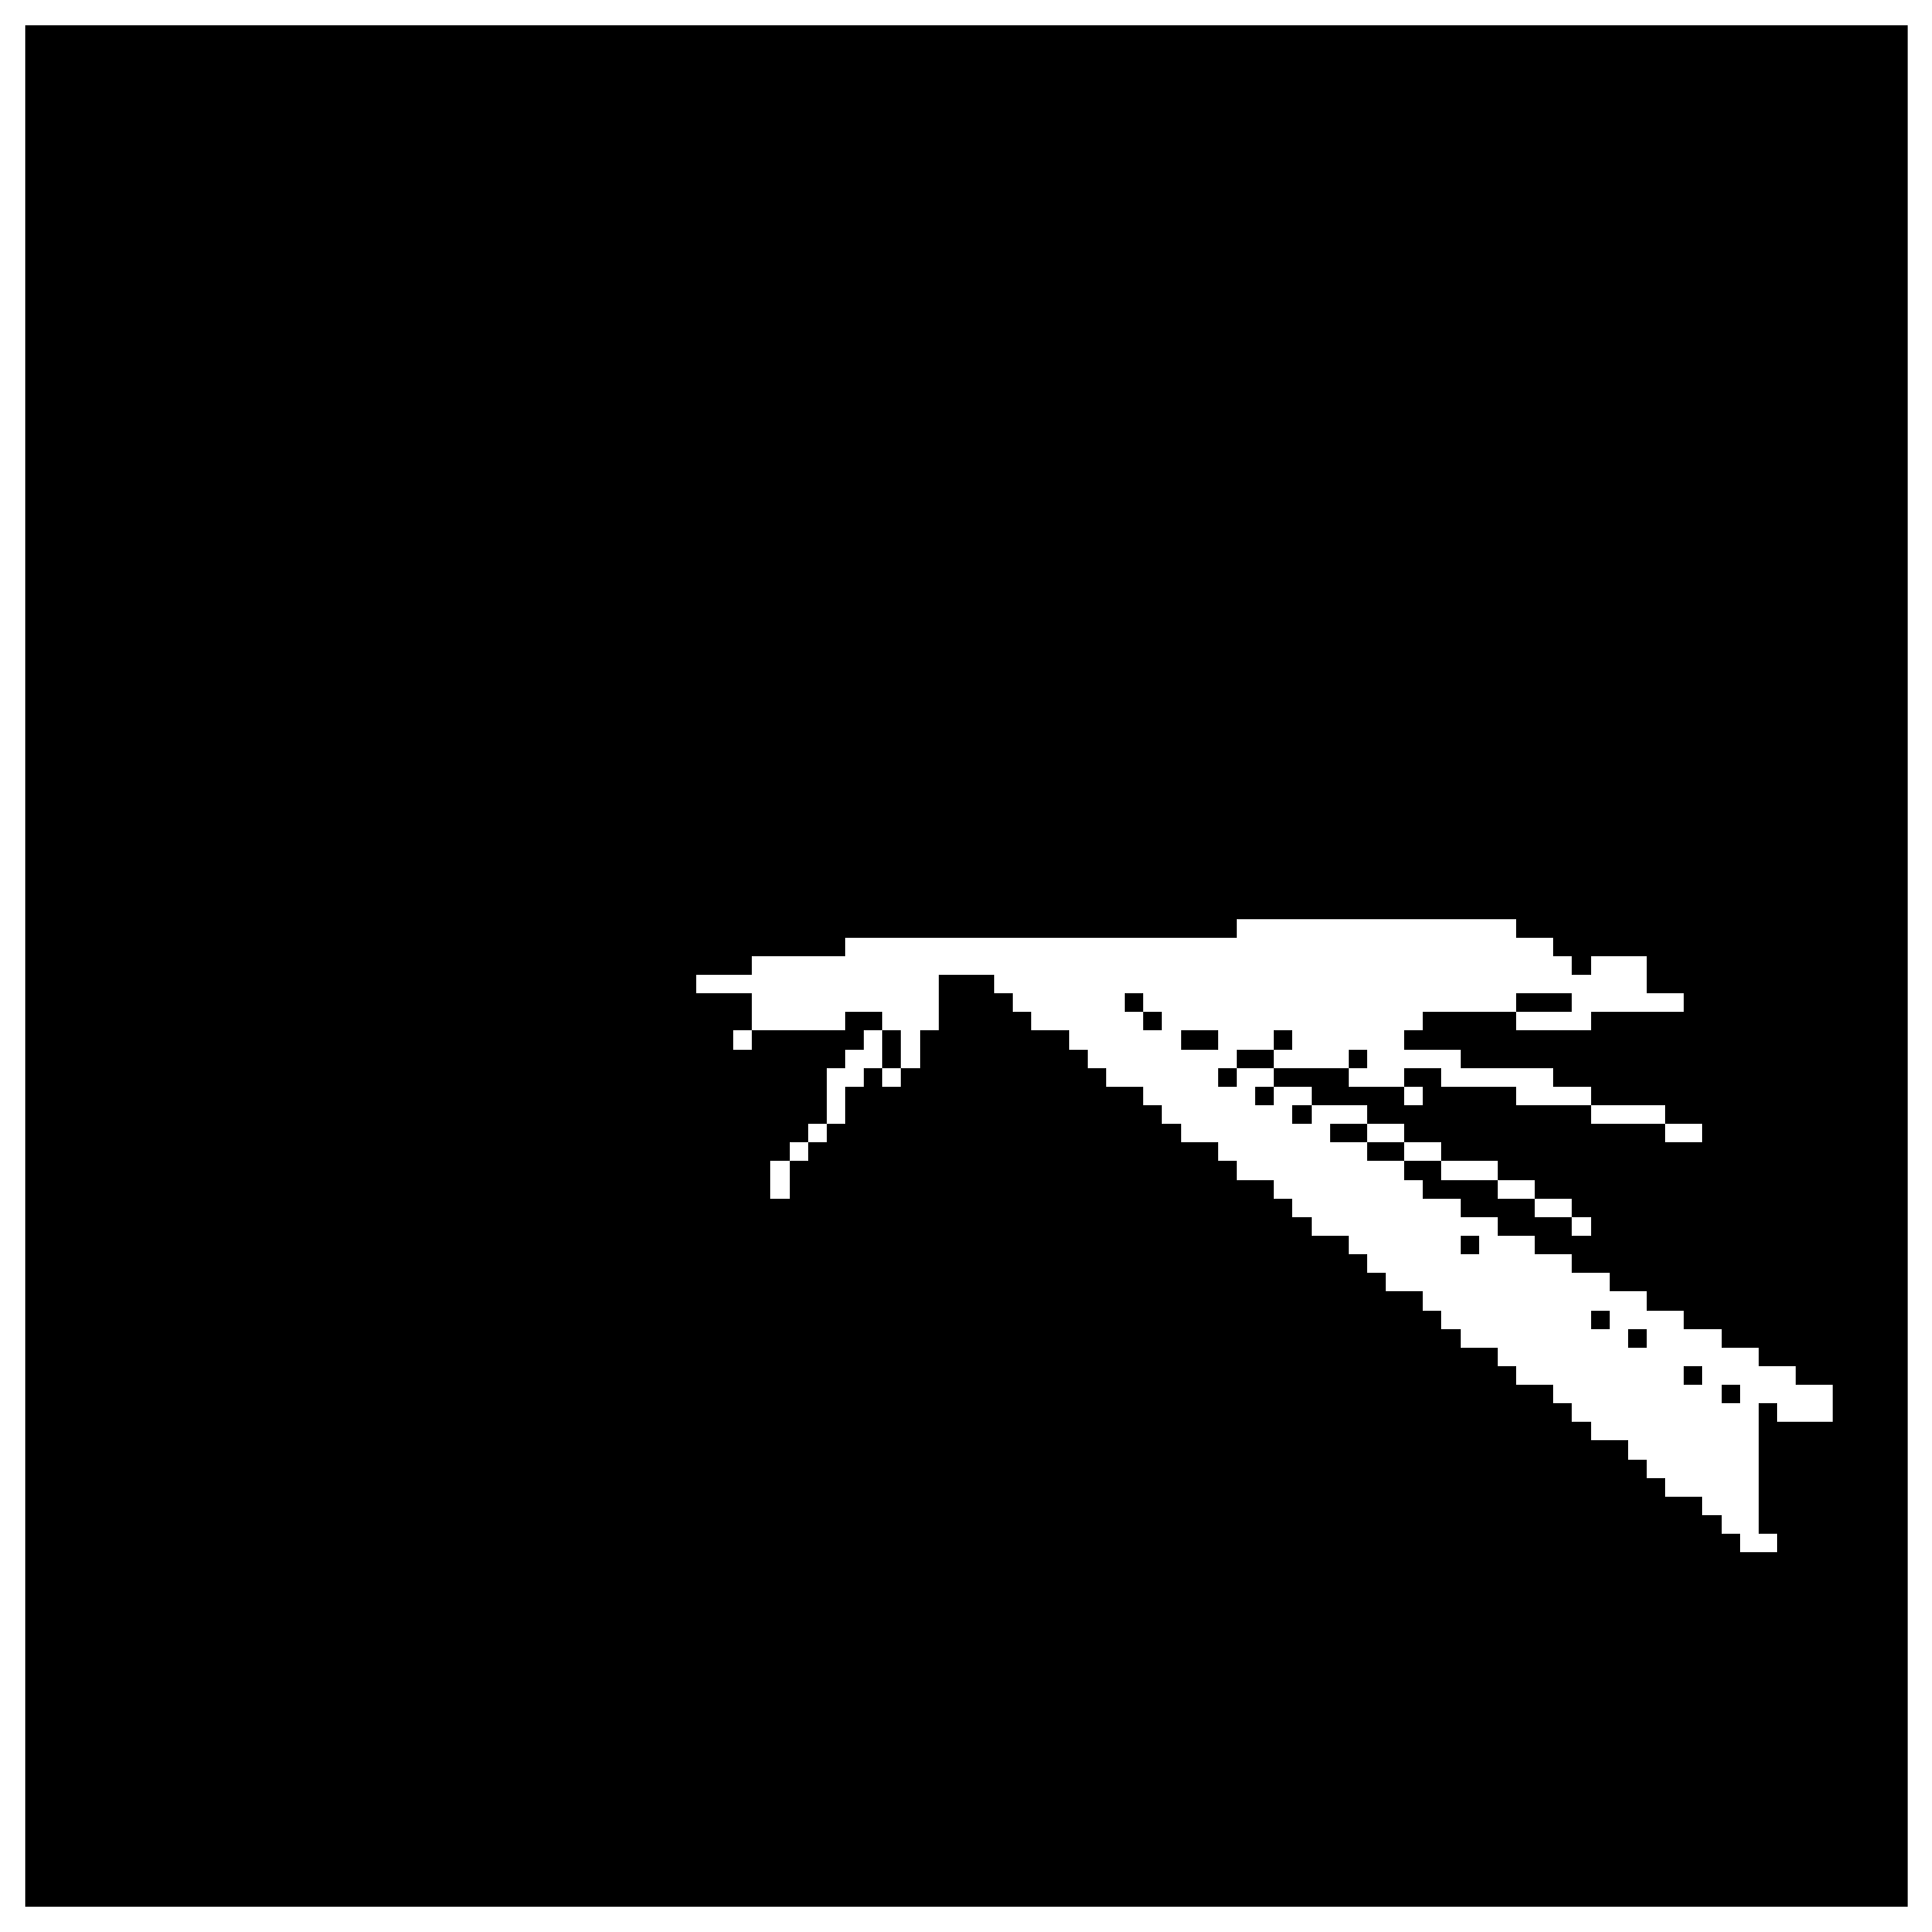

In [241]:
# Initilize the map
current_lidar_data = lidar_data[global_lidar_counter]
global_lidar_counter = global_lidar_counter + 1  # update the lidar count so it will read next time
Y_World = convert_lidar_to_cell_new(alpha, mu, first_lidar_data, angle, NUMBER_OF_PARTICLES)
log_map, grid_map, free_map = log_odds_function(mu[0], log_map, grid_map, free_map, Y_World[:, :, 0])
folder = "D:/University of California San Diego/Quater 2/ECE276A/Assignment 2/harsh_ece276a_pr2/report/Images/"
name = "first_lidar.png"

plt.figure(figsize=(10, 10), dpi=256)
plt.imshow(log_map, cmap="gray")
plt.axis('off')
plt.savefig(folder+name)
plt.show()
# plt.imshow((grid_map), cmap="gray")

# print(mu)
# print(alpha)

In [41]:
# mu = prediction_step(alpha, mu, robot=True)
# alpha, log_map, grid_map, free_map = update_step(mu, alpha, Y_World, log_map, grid_map, free_map)

In [42]:
folder_grid_map = "data/output/grid_map/"
folder_log_map = "data/output/log_map/"
folder_free_map = "data/output/free_map/"

# Initilize the map
current_lidar_data = lidar_data[global_lidar_counter]
global_lidar_counter = global_lidar_counter + 1  # update the lidar count so it will read next time
Y_World = convert_lidar_to_cell_new(alpha, mu, first_lidar_data, angle, NUMBER_OF_PARTICLES)
log_map, grid_map, free_map = log_odds_function(mu[0], log_map, grid_map, free_map, Y_World[:, :, 0])

# Create a figure size
plt.figure(figsize=(20, 10), dpi=128)

# for i in range(115864):
# for i in range(1000):
for i in tqdm(range(0, 115864)):
    mu = prediction_step(alpha, mu, robot=True)        
    # if i% 10000 == 0:
        # plt.figure(figsize=(20, 100), dpi=128)
        # name = "img" + str(i) + ".png"
        # robot_path_temp = np.array(robot_path)
        # x, y = robot_path_temp[:, :, 0], robot_path_temp[:, :, 1]
        # xr = np.ceil((x - map_x_min) / map_res ).astype(np.int16)-1
        # yr = np.ceil((y - map_y_min) / map_res ).astype(np.int16)-1 
        
        # plt.figure(figsize=(20, 10), dpi=128)
        # plt.imshow((free_map), cmap="gray")
        # plt.scatter(yr, xr, s=0.0005, color="b")
        # plt.axis('off')
        # plt.savefig(folder+name)
        # plt.show()
        # plt.close()
      
    if i%100 == 0:
        # print("I: ", i)        
        # Create the path of the robot
        robot_path_temp = np.array(robot_path)
        
        x, y = robot_path_temp[:, :, 0], robot_path_temp[:, :, 1]
        xr = np.ceil((x - map_x_min) / map_res ).astype(np.int16)-1
        yr = np.ceil((y - map_y_min) / map_res ).astype(np.int16)-1
        
        # Save the image to create a video
        # Why?
        # Just because you look cool
        num = str(i)
        num = num.zfill(6)
        
        # This is for free map
        gc.collect()
        name = "img" + str(num) + ".png"
        plt.imshow((free_map), cmap="gray")
        plt.scatter(yr, xr, s=0.001, color="b")
        plt.axis('off')        
        plt.savefig(folder_free_map+name, bbox_inches='tight')
        plt.clf()
        
        # This is for log map
        gc.collect()        
        name = "img" + str(num) + ".png"
        plt.imshow((log_map), cmap="gray")
        plt.scatter(yr, xr, s=0.001, color="b")
        plt.axis('off')
        plt.savefig(folder_log_map+name, bbox_inches='tight')
        plt.clf()
        
        # This is for grid map
        gc.collect()        
        name = "img" + str(num) + ".png"
        plt.imshow((grid_map), cmap="gray")
        plt.scatter(yr, xr, s=0.001, color="b")
        plt.axis('off')
        plt.savefig(folder_grid_map+name, bbox_inches='tight')
        plt.clf()
        
    if i%5 == 0:        
        alpha, log_map, grid_map, free_map = update_step(mu, alpha, Y_World, log_map, grid_map, free_map)
        alpha, mu = resmaple_step(alpha, mu)
        
    else:
        global_lidar_counter = global_lidar_counter + 1


global_lidar_counter = global_lidar_counter - 1        
# Predict and update for the last time frame
mu = prediction_step(alpha, mu, robot=True)
alpha, log_map, grid_map, free_map = update_step(mu, alpha, Y_World, log_map, grid_map, free_map)

# Create the last graph as well
gc.collect()
print("I: ", i)
# Create the path of the robot
robot_path_temp = np.array(robot_path)
        
x, y = robot_path_temp[:, :, 0], robot_path_temp[:, :, 1]
xr = np.ceil((x - map_x_min) / map_res ).astype(np.int16)-1
yr = np.ceil((y - map_y_min) / map_res ).astype(np.int16)-1
        
# Save the image to create a video
# Why?
# Just because you look cool
num = str(i)
num = num.zfill(6)
        
# This is for free map
gc.collect()
name = "img" + str(num) + ".png"
plt.imshow((free_map), cmap="gray")
plt.scatter(yr, xr, s=0.001, color="b")
plt.axis('off')        
plt.savefig(folder_free_map+name, bbox_inches='tight')
plt.clf()
        
# This is for log map
gc.collect()        
name = "img" + str(num) + ".png"
plt.imshow((log_map), cmap="gray")
plt.scatter(yr, xr, s=0.001, color="b")
plt.axis('off')
plt.savefig(folder_log_map+name, bbox_inches='tight')
plt.clf()
        
# This is for grid map
gc.collect()        
name = "img" + str(num) + ".png"
plt.imshow((grid_map), cmap="gray")
plt.scatter(yr, xr, s=0.001, color="b")
plt.axis('off')
plt.savefig(folder_grid_map+name, bbox_inches='tight')
plt.clf()

100%|████████████████████████████████████████████████████████████████████████| 115864/115864 [1:06:25<00:00, 29.07it/s]


I:  115863


<Figure size 2560x1280 with 0 Axes>

In [43]:
robot_path_temp = np.array(robot_path)
x, y = robot_path_temp[:, :, 0], robot_path_temp[:, :, 1]
xr = np.ceil((x - map_x_min) / map_res ).astype(np.int16)-1
yr = np.ceil((y - map_y_min) / map_res ).astype(np.int16)-1

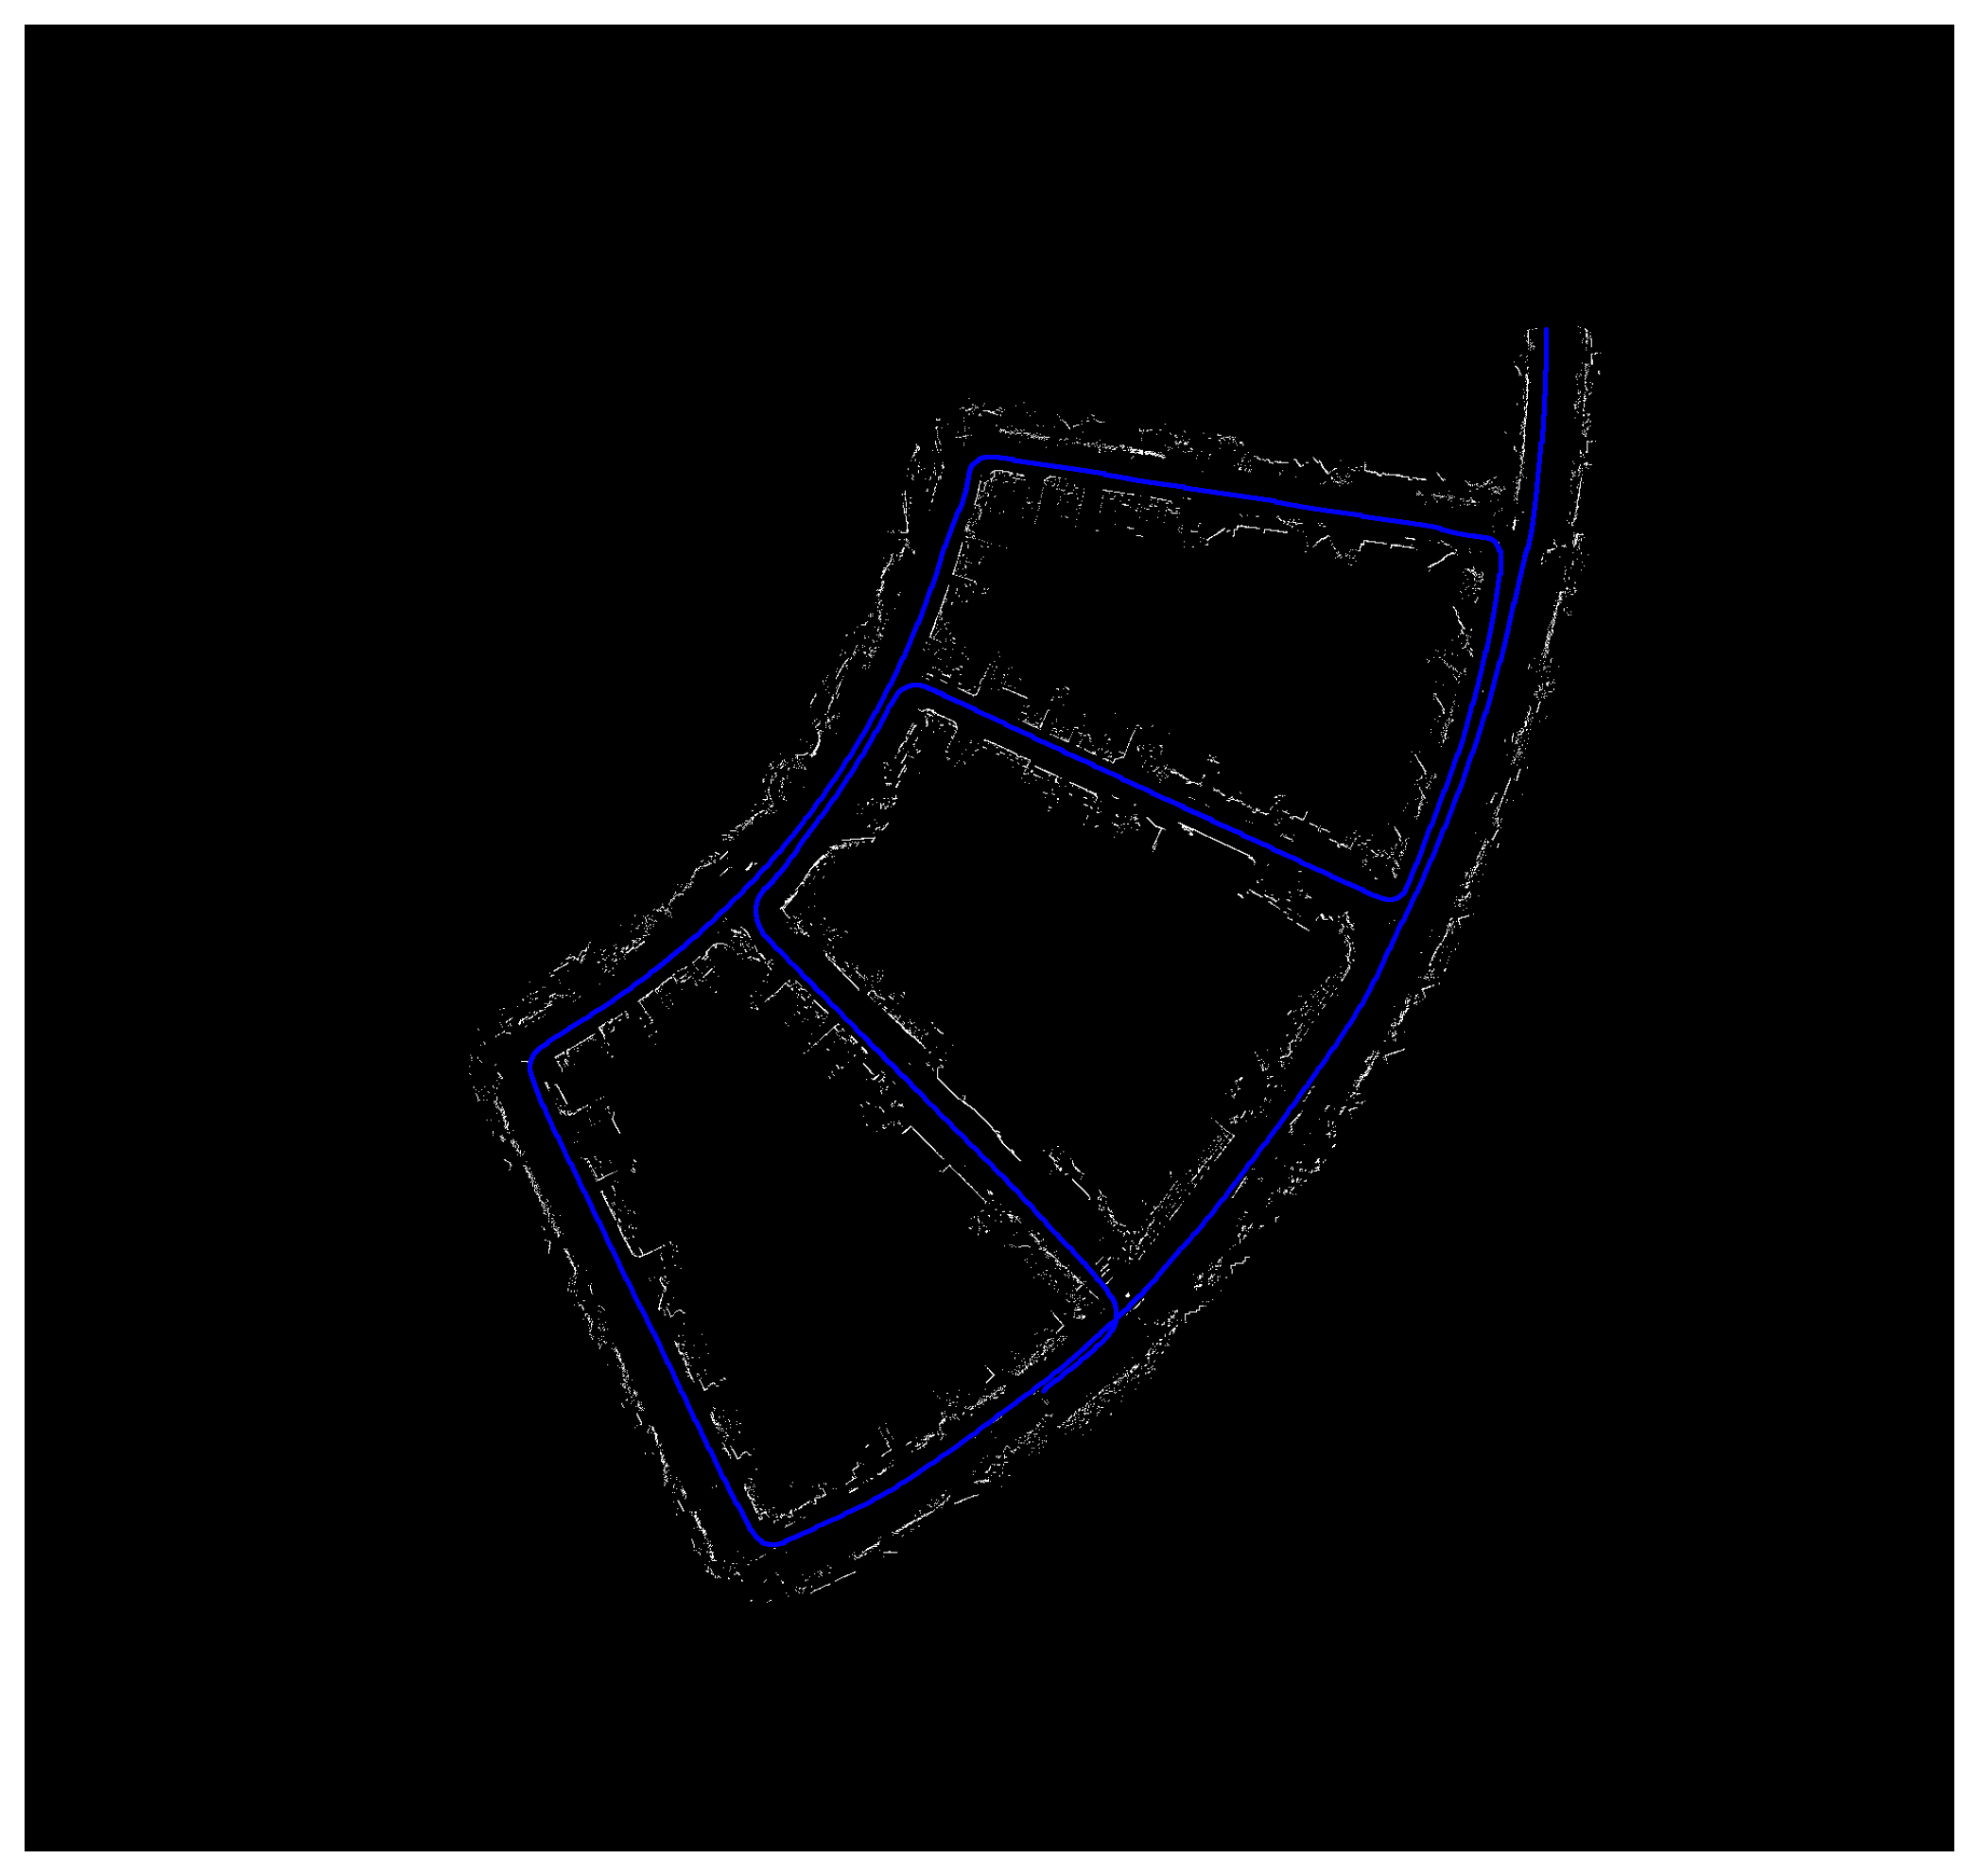

In [44]:
i = 0
folder = "data/output/grid_map/"
name = "grid" + str(i) + ".png"

plt.figure(figsize=(20, 10), dpi=256)
plt.imshow((grid_map), cmap="gray")
plt.scatter(yr, xr, s=0.005, color="b")
plt.axis('off')
plt.savefig(folder+name, bbox_inches='tight')
plt.show()

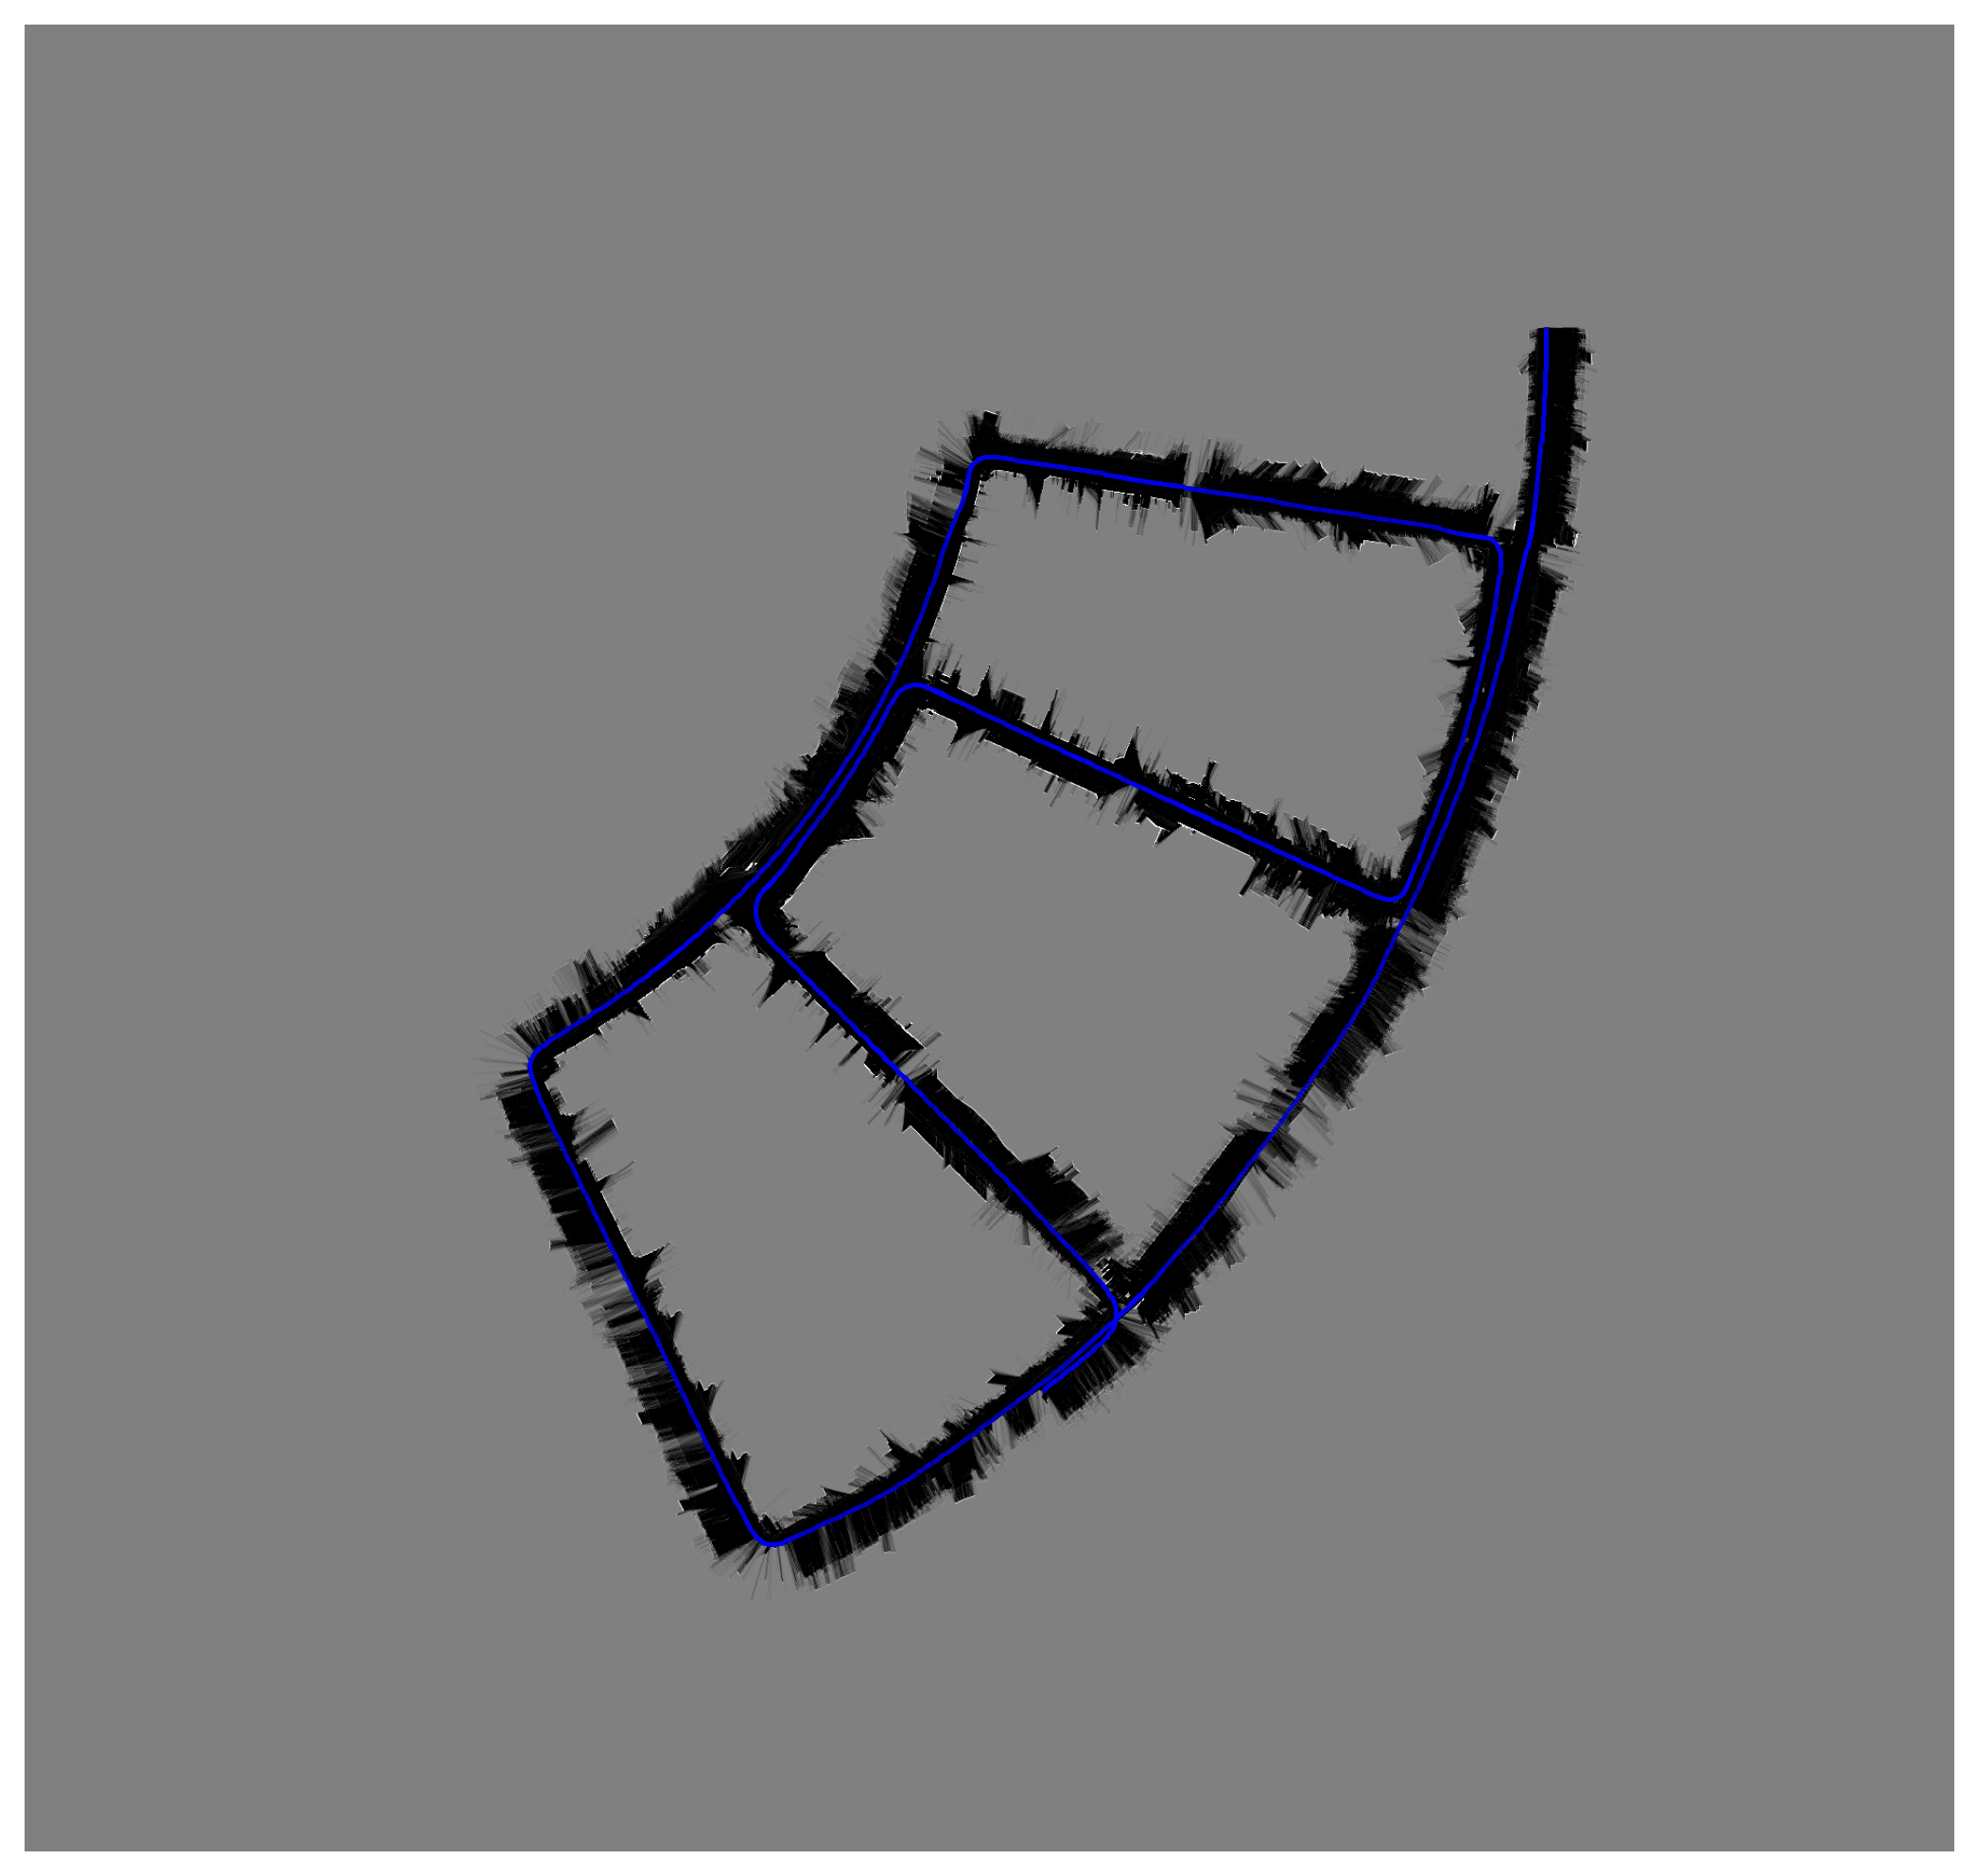

In [45]:
i = 0
folder = "data/output/log_map/"
name = "log" + str(i) + ".png"

plt.figure(figsize=(20, 10), dpi=256)
plt.imshow((log_map), cmap="gray")
plt.scatter(yr, xr, s=0.0005, color="b")
plt.axis('off')
plt.savefig(folder+name, bbox_inches='tight')
plt.show()

In [46]:
print(lidar_data.shape)
print(wheel_count.shape)
print(fog_yaw.shape)


(115865, 286)
(116048, 2)
(1160508,)


In [47]:
# Video Generating function
def generate_video(image_folder):
    # image_folder = '.' # make sure to use your folder
    video_name = 'output_video.avi'
    os.chdir(image_folder)
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")]
     
    # Array images should only consider
    # the image files ignoring others if any
    # print(images) 
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, 0, 30, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
      
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated

In [142]:
left_proj_matrix = np.array([[ 7.7537235550066748e+02,                     0., 6.1947309112548828e+02, 0.], 
                             [                     0., 7.7537235550066748e+02, 2.5718049049377441e+02, 0.], 
                             [                     0.,                     0.,                     1., 0.]])
# 368.4132123724365

K = np.array([[ 7.7537235550066748e+02,                     0., 6.1947309112548828e+02], 
              [                     0., 7.7537235550066748e+02, 2.5718049049377441e+02], 
              [                     0.,                     0.,                     1.]])
K_1 = np.linalg.inv(K)

stereo_base = 0.475143600050775

v_T_s = np.array([[ -0.00680499,  -0.0153215,     0.99985,  1.64239],
                  [   -0.999977, 0.000334627, -0.00680066, 0.247401],
                  [-0.000230383,   -0.999883,  -0.0153234,  1.58411],
                  [          0.,          0.,          0.,       1.]])

s_T_v = np.array([[-0.0068,   -1.0000,   -0.0002, 0.2589],
                  [-0.0153,    0.0003,   -0.9999, 1.6090],
                  [0.9999,   -0.0068,   -0.0153, -1.6162],
                  [     0,         0,         0,       1]])

In [99]:
# This is to load pickle
d_img = pkl.load(open(str(dis_path+"disparity.pkl"), "rb"))
r_img = pkl.load(open(str(rgb_path+"rgb.pkl"), "rb"))
print(d_img.shape)
print(r_img.shape)

(1113, 560, 1280)
(1113, 560, 1280, 3)


In [220]:
# texture_map = np.zeros((200, 200, 3), np.uint8)
texture_map = np.zeros((map_size_x, map_size_y, 3), np.uint8)
# texture_map.fill(255)

f_Su = left_proj_matrix[0][0]
path = np.array(robot_path)
print(path.shape)
# print(grid[0][0][0])

plt.figure(figsize=(50, 40), dpi=128)

d_img_len = len(d_img)
for i in tqdm(range(0, d_img_len)):
    # print()
    # print("I: ", i)
    # Find the time stamp of the stereo camera that is closest to the lidar time stamp
    current_time = stereo_time_stamp[i]
    closest_time = lidar_time_stamp.flat[np.abs(lidar_time_stamp - current_time).argmin()]
    index = np.abs(lidar_time_stamp - current_time).argmin()
    # print(current_time)
    # print(closest_time)
    # print(index)
    
    # Get a particular image for a particular stero from the pickle file
    dis_img = d_img[i]
    color_img = r_img[i]
    
    
    Z = np.divide(f_Su*stereo_base, dis_img)
    Z[Z>23] = 0
    # Z[Z>46.05165154655456] = 46.05165154655456
    # Z[Z == np.inf] = 0
    # print()
    # print("Z")
    # print(np.min(Z))
    # print(np.max(Z))
    row, col = Z.shape
    Z = np.reshape(Z, (1, row*col))
    # rgb_img = np.reshape(rgb_img, (row*col, 3))
    # print(img[:, 0].shape)
    
    
    # u, v = np.meshgrid(np.arange(0, col), np.arange(0, row))
    # u, v, ones = np.reshape(v, (1,row*col)), np.reshape(u, (1, row*col)), np.ones((row*col))
    ones = np.ones((1, row*col))
    # d = np.full((1, row*col), f_Su*stereo_base)
    grid_uv = np.indices((560,1280))
    # grid_uv = np.asarray(np.meshgrid(np.arange(0, row), np.arange(0,col)))
    # print()
    # print("grid")
    # print(grid.shape)
    
    grid_uv = grid_uv.reshape((2,-1))    
    # print()
    # print("grid")
    # print(grid_uv.shape)
    
    uv_grid = np.vstack((grid_uv[1], grid_uv[0]))
    # print()
    # print(grid_uv.shape)
    uv_grid  = np.vstack((uv_grid, ones))
    # print()
    # print("U, V, 1")
    # print(u, v, ones.shape)
    # uv_grid = np.stack((u, v, ones))
    # print(uv_grid)
    
    new_coordinates = Z * (K_1 @ uv_grid)
    X, Y = new_coordinates[:2]
    stereo_coordinates = np.vstack((X, Y, Z, ones))
    # print()
    # print("Stereo Coordinate")
    # print(stereo_coordinates.shape)
    # print(stereo_coordinates)
    
    
    # Get the pose matrix at this position
    # w_T_r
    x, y, theta = np.asarray([path[index, :, 0]]), np.array([path[index, :, 1]]), np.array([path[index, :, 2]])
    w_T_v = world_T_vehicle(theta, x, y, NUMBER_OF_PARTICLES=1)
    
    world_coordinates = (w_T_v @ v_T_s @ stereo_coordinates)[0]
    # print()
    # print("World_Coordinates")
    # print(world_coordinates.shape)
    # print(world_coordinates[2])
    
    Xw, Yw, Zw = world_coordinates[0], world_coordinates[1], world_coordinates[2]
    # Xw, Yw, Zw = np.reshape(Xw, (row, col)), np.reshape(Yw, (row,col)), np.reshape(Zw, (row, col))
    
    # print()
    # print("Zw")
    # print(np.min(Zw))    
    # print(np.max(Zw))
    # print(Zw)
    
    # good_index = np.logical_and(Zw>-17, Zw<15)
    # good_index = np.where(((Zw>-5) & (Zw<-1)) | ((Zw>1) & (Zw<5)))[0]
    good_index = np.where((Zw>-4) & (Zw<4))[0]
    # good_index = Zw>0.1
    # good_index = np.where((Zw>10))[0]
    # print()
    # print("good_index") 
    # print(good_index)
    # print(good_index.shape)
    
    world_coordinates = world_coordinates[:, good_index]
    stereo_coordinates = stereo_coordinates[:, good_index]
    # uv = np.divide(left_proj_matrix @ stereo_coordinates, world_coordinates[2])[:2]
    uv = np.divide(left_proj_matrix @ world_coordinates, stereo_coordinates[2])[:2]
    uv = np.around(uv).astype(np.int16)
    
    # print()
    # print("UV Values")
    # print(uv.shape)
    # print(np.min(uv[0]))
    # print(np.max(uv[0]))
    
    u = grid_uv[0][uv[0]]
    v = grid_uv[1][uv[1]]
    # print()
    # print("U Values")
    # print(u.shape)
    # print(np.min(u))
    # print(np.max(u))
        
    x_rgb = np.ceil((world_coordinates[0] - map_x_min) / map_res ).astype(np.int16)-1
    y_rgb = np.ceil((world_coordinates[1] - map_y_min) / map_res ).astype(np.int16)-1
    # x_rgb = np.ceil((world_coordinates[0] - (-50)) / map_res ).astype(np.int16)-1
    # y_rgb = np.ceil((world_coordinates[1] - (-50)) / map_res ).astype(np.int16)-1
    
    # print()
    # print("x_rgb")
    # print(x_rgb)
    
    # print()
    # print("uv")
    # print(uv.shape)
    
    # texture_map[x_rgb, y_rgb, :] = rgb_img[position_y, position_x]
    texture_map[x_rgb, y_rgb, :] = r_img[i][u, v]
    # plt.imshow(texture_map)

    
    '''
    if i%5 == 0:
        # This is for texture map
        path_x, path_y = path[:index, :, 0], robot_path_temp[:index, :, 1]
        xr = np.ceil((path_x - map_x_min) / map_res ).astype(np.int16)-1
        yr = np.ceil((path_y - map_y_min) / map_res ).astype(np.int16)-1

        gc.collect()
        num = str(i)
        num = num.zfill(4)
        name = "img" + str(num) + ".png"
        plt.imshow((texture_map))
        plt.scatter(yr, xr, s=0.001, color="b")
        plt.axis('off')
        plt.savefig(texture_map_folder+name, bbox_inches='tight')
        plt.clf()
    '''

(115866, 1, 3)


  0%|                                                                                         | 0/1113 [00:00<?, ?it/s]C:\Users\harsh\AppData\Local\Temp/ipykernel_40452/2925225432.py:29: RuntimeWarning: divide by zero encountered in true_divide
  Z = np.divide(f_Su*stereo_base, dis_img)
C:\Users\harsh\AppData\Local\Temp/ipykernel_40452/2925225432.py:110: RuntimeWarning: divide by zero encountered in true_divide
  uv = np.divide(left_proj_matrix @ world_coordinates, stereo_coordinates[2])[:2]
100%|██████████████████████████████████████████████████████████████████████████████| 1113/1113 [03:09<00:00,  5.88it/s]


<Figure size 6400x5120 with 0 Axes>

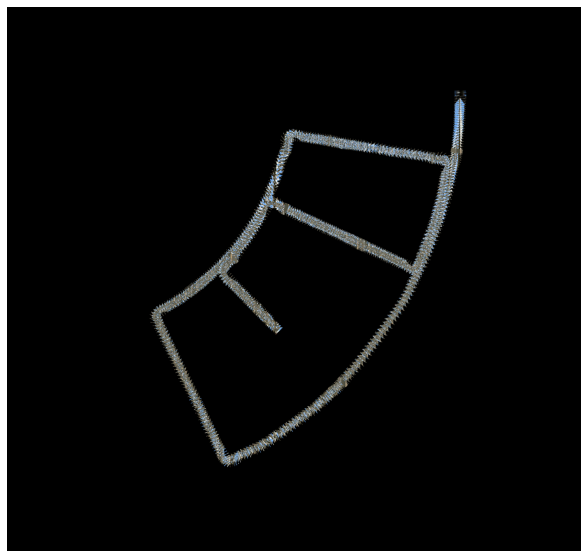

In [223]:
i = 0
current_dir = "D:/University of California San Diego/Quater 2/ECE276A/Assignment 2/ECE276A_PR2/code/"
folder = "/data/output/free_map/"
name = "free" + str(i) + ".png"

path_x, path_y = path[:index, :, 0], robot_path_temp[:index, :, 1]
xr = np.ceil((path_x - map_x_min) / map_res ).astype(np.int16)-1
yr = np.ceil((path_y - map_y_min) / map_res ).astype(np.int16)-1
        
plt.figure(figsize=(20, 10))
plt.imshow(texture_map)
# plt.scatter(yr, xr, s=0.001, color="b")
plt.axis('off')
plt.savefig(texture_map_folder+name, bbox_inches='tight')
plt.show()

In [51]:
# Calling the generate_video function
generate_video("D://University of California San Diego//Quater 2//ECE276A//Assignment 2//ECE276A_PR2//code//data//output//log_map")